# HealthBot - AI-Powered Patient Education Agent
# Complete Implementation for Turing College Sprint 3

## Overview
This notebook demonstrates a complete AI health education agent built with:
- LangGraph for workflow orchestration
- OpenAI for LLM capabilities
- Wikipedia & Tavily for research
- Streamlit for user interface
- Memory for conversation persistence

In [28]:
# !pip install streamlit langchain langchain-openai langchain-community langgraph tavily-python python-dotenv pydantic typing-extensions

In [29]:
import os
from dotenv import load_dotenv

load_dotenv()
print("Environment Setup Complete")
print(f"OpenAI API Key: {'Found' if os.getenv('OPENAI_API_KEY') else 'Missing'}")
print(f"Tavily API Key: {'Found' if os.getenv('TAVILY_API_KEY') else 'Missing'}")

Environment Setup Complete
OpenAI API Key: Found
Tavily API Key: Found


In [30]:
# Cell 3: Define Data Schemas
"""
## Data Models & Schemas
Define Pydantic models for type safety and data validation.
These schemas ensure consistent data flow through our agent.
"""

from typing import List, Dict, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class UserInput(BaseModel):
    symptoms: str = Field(description="User's described symptoms")
    age: Optional[int] = Field(description="User's age")
    gender: Optional[str] = Field(description="User's gender")

class HealthAgentState(TypedDict):
    user_input: UserInput
    research_content: str
    response: str
    personality: str
    conversation_history: List[str]
    openai_settings: Dict[str, float]

print("Data schemas defined successfully")

Data schemas defined successfully


In [31]:
# Cell 4: Configuration & Prompts
"""
## Configuration Settings
Define agent personalities, prompts, and default settings.
The medical disclaimer ensures legal compliance and user safety.
"""

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Medical disclaimer for legal compliance
MEDICAL_DISCLAIMER = """
⚠️ **EDUCATIONAL PURPOSES ONLY - NOT MEDICAL ADVICE**
This information is for educational purposes only. Always consult with a qualified healthcare professional for medical concerns. In case of emergency, contact emergency services immediately.
"""

# Agent personalities for different user preferences
PERSONALITIES = {
    "friendly": "You are a warm, caring health educator providing friendly educational health information.",
    "formal": "You are a professional medical educator providing precise, clinical educational information.", 
    "concise": "You are a direct health educator providing clear, concise educational health information."
}

# Main health analysis prompt with non-health query filtering
HEALTH_PROMPT = """You are a health education specialist providing concise educational information.

User input: {symptoms}
Additional info: Age: {age}, Gender: {gender}

Determine if this is health-related by checking for:
- Body parts (chest, head, stomach, etc.)
- Symptoms (pain, fatigue, nausea, etc.) 
- Medical terms (vitamin, supplement, medication, etc.)
- Follow-up questions about previous health topics

If NOT health-related, respond ONLY with:
"I'm a health education assistant. Please ask about symptoms, medical concerns, supplements, or health-related topics."

If IS health-related, provide brief educational information:
1. Most likely causes (2-3 conditions max)
2. When to seek care (urgent vs routine)
3. Key supplements/recommendations (2-3 items)

Keep response concise but complete. Include medical disclaimer.

Research context:
{research_content}
"""

# Default OpenAI settings for consistent responses
DEFAULT_OPENAI_SETTINGS = {
    "temperature": 0.3,
    "top_p": 0.9,
    "max_tokens": 1000
}

print("Configuration loaded successfully")

Configuration loaded successfully


In [32]:
# Cell 5: Search Tools Implementation
"""
## Research Tools
Implement Wikipedia and Tavily search functions for gathering medical information.
These tools provide the knowledge base for our health education responses.
"""

from langchain_community.document_loaders import WikipediaLoader
from pydantic import BaseModel, Field

# Handle Tavily import gracefully
try:
    from langchain_community.tools.tavily_search import TavilySearchResults
except ImportError:
    TavilySearchResults = None

class SearchQuery(BaseModel):
    search_query: str = Field(description="Search query for retrieval")

def search_wikipedia(symptoms: str, max_docs: int = 2) -> str:
    """Search Wikipedia for medical information about symptoms"""
    try:
        search_query = f"{symptoms} medical symptoms causes treatment"
        loader = WikipediaLoader(query=search_query, load_max_docs=max_docs)
        docs = loader.load()
        
        formatted_docs = "\n\n---\n\n".join([
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ])
        
        return formatted_docs
        
    except Exception as e:
        return f"Error searching Wikipedia: {str(e)}"

def search_tavily(symptoms: str, max_results: int = 3) -> str:
    """Search web using Tavily for current medical information"""
    try:
        if not TavilySearchResults:
            return "Tavily search not available"
            
        tavily_search = TavilySearchResults(
            max_results=max_results,
            api_key=TAVILY_API_KEY
        )
        
        search_query = f"{symptoms} symptoms medical information causes treatment"
        search_docs = tavily_search.invoke(search_query)
        
        formatted_docs = "\n\n---\n\n".join([
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ])
        
        return formatted_docs
        
    except Exception as e:
        return f"Error searching Tavily: {str(e)}"

def combine_search_results(wikipedia_results: str, tavily_results: str) -> str:
    """Combine and format search results from multiple sources"""
    combined = []
    
    if wikipedia_results and "Error" not in wikipedia_results:
        combined.append("## Wikipedia Sources:\n" + wikipedia_results)
    
    if tavily_results and "Error" not in tavily_results:
        combined.append("## Web Sources:\n" + tavily_results)
    
    if not combined:
        return "No reliable medical information found. Please consult a healthcare professional."
    
    return "\n\n".join(combined)

print("Search tools implemented successfully")


Search tools implemented successfully


In [33]:
# Cell 6: Main Health Agent
"""
## HealthBot Agent Implementation
The core agent using LangGraph for workflow orchestration.
This handles the complete flow: research → analysis → response with memory.
"""

from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

class HealthAgent:
    def __init__(self, openai_settings=None):
        self.openai_settings = openai_settings or {}
        self.llm = ChatOpenAI(
            model="gpt-4o-mini",
            temperature=self.openai_settings.get("temperature", 0.3),
            top_p=self.openai_settings.get("top_p", 0.9),
            max_tokens=self.openai_settings.get("max_tokens", 1000)
        )
        
        self.memory = MemorySaver()
        self.graph = self._build_graph()
    
    def _build_graph(self):
        """Build the LangGraph workflow"""
        builder = StateGraph(HealthAgentState)
        
        builder.add_node("research_symptoms", self._research_symptoms)
        builder.add_node("generate_response", self._generate_response)
        
        builder.add_edge(START, "research_symptoms")
        builder.add_edge("research_symptoms", "generate_response")
        builder.add_edge("generate_response", END)
        
        return builder.compile(checkpointer=self.memory)
    
    def _research_symptoms(self, state: HealthAgentState):
        """Research symptoms using Wikipedia and Tavily"""
        user_input = state["user_input"]
        symptoms = user_input.symptoms
        
        wikipedia_results = search_wikipedia(symptoms)
        tavily_results = search_tavily(symptoms)
        research_content = combine_search_results(wikipedia_results, tavily_results)
        
        return {"research_content": research_content}
    
    def _generate_response(self, state: HealthAgentState):
        """Generate educational health response with conversation memory"""
        user_input = state["user_input"]
        research_content = state["research_content"]
        personality = state.get("personality", "friendly")
        conversation_history = state.get("conversation_history", [])
        
        system_prompt = PERSONALITIES[personality]
        
        # Add conversation context for memory
        context = ""
        if conversation_history:
            context = f"Previous conversation:\n{chr(10).join(conversation_history[-6:])}\n\n"
        
        health_prompt = HEALTH_PROMPT.format(
            symptoms=user_input.symptoms,
            age=user_input.age or "Not specified", 
            gender=user_input.gender or "Not specified",
            research_content=research_content
        )
        
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=context + health_prompt)
        ]
        
        response = self.llm.invoke(messages)
        
        # Update conversation history for memory
        new_history = conversation_history + [
            f"User: {user_input.symptoms}",
            f"Assistant: {response.content[:200]}..."
        ]
        
        return {
            "response": response.content + "\n\n" + MEDICAL_DISCLAIMER,
            "conversation_history": new_history
        }
    
    def process_symptoms(self, user_input: UserInput, personality: str = "friendly", thread_id: str = "default"):
        """Main method to process user symptoms with memory"""
        thread = {"configurable": {"thread_id": thread_id}}
        
        result = self.graph.invoke({
            "user_input": user_input,
            "personality": personality,
            "openai_settings": self.openai_settings
        }, thread)
        
        return result

print("HealthBot agent implemented successfully")


HealthBot agent implemented successfully


In [34]:
# Cell 7: Test the Agent
"""
## Agent Testing
Test the HealthBot with sample health queries to verify functionality.
"""

# Initialize the agent
agent = HealthAgent()

# Test with a sample health query
test_input = UserInput(
    symptoms="I have been experiencing headaches and fatigue for 3 days",
    age=25,
    gender="female"
)

print("Testing HealthBot with sample query...")
result = agent.process_symptoms(test_input, personality="friendly")

print("Test Results:")
print("=" * 50)
print(result["response"][:500] + "...")
print("=" * 50)
print("Agent test completed successfully")

🧪 Testing HealthBot with sample query...
Test Results:
Experiencing headaches and fatigue for three days can be health-related. Here’s some brief educational information:

1. **Most Likely Causes**:
   - **Tension-Type Headaches**: These are common and often linked to stress, fatigue, or dehydration.
   - **Viral Infections**: Conditions like the flu or a cold can cause both headaches and fatigue.

2. **When to Seek Care**:
   - **Urgent Care**: Seek immediate medical attention if your headache is sudden and severe, or if you experience symptoms lik...
Agent test completed successfully


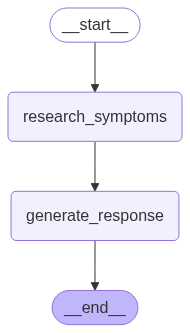

Workflow diagram generated successfully


In [35]:
# Cell 8: Workflow Visualization
"""
## LangGraph Workflow Diagram
Generate and display the agent's workflow diagram using Mermaid.
"""

from IPython.display import Image, display

try:
    # Generate workflow diagram
    workflow_image = agent.graph.get_graph().draw_mermaid_png()
    display(Image(workflow_image))
    print("Workflow diagram generated successfully")
except Exception as e:
    print(f"Could not generate diagram: {e}")
    print("Workflow: START → research_symptoms → generate_response → END")

## Interactive Testing & Demo
Test the HealthBot with different scenarios to showcase functionality.

In [36]:
# Test 1: Basic symptom analysis
print("Test 1: Basic Symptoms")
test1 = UserInput(symptoms="headache and fatigue for 2 days", age=30, gender="male")
result1 = agent.process_symptoms(test1, "friendly")
print("Response:", result1["response"][:300] + "...")

Test 1: Basic Symptoms
Response: Experiencing headaches and fatigue for two days can be health-related. Here’s some brief educational information:

1. **Most Likely Causes**:
   - **Tension-Type Headaches**: Often caused by stress, fatigue, or dehydration, presenting as a band-like pressure around the head.
   - **Viral Infections*...


In [37]:
# Test 2: Supplement question
print("Test 2: Supplement Query")
test2 = UserInput(symptoms="what vitamins for immune system", age=25, gender="female")
result2 = agent.process_symptoms(test2, "concise")
print("Response:", result2["response"][:300] + "...")

Test 2: Supplement Query
Response: Experiencing questions about vitamins for the immune system is health-related. Here’s some brief educational information:

1. **Key Vitamins for Immune Support**:
   - **Vitamin C**: Important for the growth and function of immune cells.
   - **Vitamin D**: Plays a crucial role in immune response an...


In [38]:
# Test 3: Non-health query (should redirect)
print("Test 3: Non-Health Query")
test3 = UserInput(symptoms="weather today", age=None, gender=None)
result3 = agent.process_symptoms(test3, "formal")
print("Response:", result3["response"])

Test 3: Non-Health Query
Response: I'm a health education assistant. Please ask about symptoms, medical concerns, supplements, or health-related topics.


⚠️ **EDUCATIONAL PURPOSES ONLY - NOT MEDICAL ADVICE**
This information is for educational purposes only. Always consult with a qualified healthcare professional for medical concerns. In case of emergency, contact emergency services immediately.



In [39]:
# Test 4: Memory demonstration (follow-up question)
print("Test 4: Memory Test")
test4 = UserInput(symptoms="what should I do if it gets worse?", age=None, gender=None)
result4 = agent.process_symptoms(test4, "friendly", thread_id="default")
print("Response:", result4["response"][:300] + "...")

Test 4: Memory Test
Response: If your symptoms of headache and fatigue are getting worse, here’s what you should consider:

1. **Most Likely Causes**:
   - **Viral Infections**: Common colds or flu can lead to increased fatigue and headaches.
   - **Tension or Migraines**: Stress or changes in sleep patterns can exacerbate heada...
